### CONFIG:

In [ ]:
IS_DTRAK = True
IS_LoRA = True
SWAP_DATASETS = True

UPDATE_SCORES = True
GENERATE_COUNTER_FACTUAL_DATASET = False

CALCULATE_LDS = False

from utils.config import Project_Config, Model_Config, CIFAR_10_Config, LoRA_Model_Config
from LDS.LDS_Utils import LDS
from TRAK.TRAK_utils import TRAK_Experiment_Config, TRAK_Type_Enum

project_config = Project_Config(
    IS_CUDA = True,
    IS_WINDOWS = False,
)

trak_config = TRAK_Experiment_Config(
    project_config=project_config,
    IS_LoRA=IS_LoRA,
    TRAK_type=(TRAK_Type_Enum.DTRAK if IS_DTRAK else TRAK_Type_Enum.TRAK),
    FORCE_FULL_MODEL_TEST_DATASET=SWAP_DATASETS,
)

model_config = trak_config.model_config

f = project_config.folder_symbol
base_save_path = (project_config.PWD + f + 
                  "datasets" + f +
                  "generated-cifar-10" + f +
                  trak_config.MODEL_NAME_CLEAN)

train_dataset_config = CIFAR_10_Config(new_image_column_name="image",
                                 new_caption_column_name="label_txt")

generated_dataset_config = CIFAR_10_Config(huggingface_slug=base_save_path, existing_image_column_name="image")

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


### Imports:

In [2]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset

In [ ]:
traker, tokenizer, text_encoder, vae, unet, ckpts = trak_config.load_TRAKer(len(train_dataset_config.dataset))

/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Dataset({
    features: ['image', 'label_txt'],
    num_rows: 50000
})
Dataset({
    features: ['image', 'label_txt'],
    num_rows: 200
})


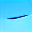

In [ ]:
train_dataset = train_dataset_config.preprocess(tokenizer)
print(train_dataset)
generated_dataset = generated_dataset_config.preprocess(tokenizer)
print(generated_dataset)

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=train_dataset_config.collate_fn,
    batch_size=1,
)

# DataLoaders creation:
generated_dataloader = DataLoader(
    generated_dataset,
    shuffle=False,
    collate_fn=generated_dataset_config.collate_fn,
    batch_size=1,
)

train_dataset_config.dataset[6]['image']
train_dataset[6]["image"]
generated_dataset_config.dataset[6]['image']
generated_dataset[6]["image"]

In [5]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
weight_dtype = torch.float32

if UPDATE_SCORES:
    for model_id, ckpt in enumerate(tqdm(ckpts)):
        if trak_config.IS_LoRA:
            p = trak_config.model_config.getModelDirectory()
            #TODO: fix the horrid local/global unet duplication going on here
            unet = model_config.loadLoRAUnet(p,ckpt)
            ckpt_local = unet.state_dict()
        else:
            ckpt_local = ckpt

        traker.start_scoring_checkpoint(exp_name=trak_config.EXPERIMENT_NAME,

                                            checkpoint=ckpt_local,

                                            model_id=model_id,

                                            num_targets=len(generated_dataloader))
        

        for batch in tqdm(generated_dataloader):
                if project_config.IS_CUDA:
                    batch = [x.cuda() for y,x in batch.items()]
                else:
                    batch = [x for y,x in batch.items()]
                image = batch[0]
                tokens = batch[1]
                # Convert images to latent space
                latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

                batch = [latents, encoder_hidden_states]
                traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name=trak_config.EXPERIMENT_NAME)

  0%|          | 0/10 [00:00<?, ?it/s]/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/diffusers/models/attention_processor.py:2358: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_efficient_attention. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  hidden_states = F.scaled_dot_product_attention(
/home/joy/miniconda3/envs/SD3HF_Unstable/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_efficient_attention_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/aten/src/ATen/functorch/BatchedFallback.c

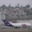

In [7]:
train_dataset[0]["image"]

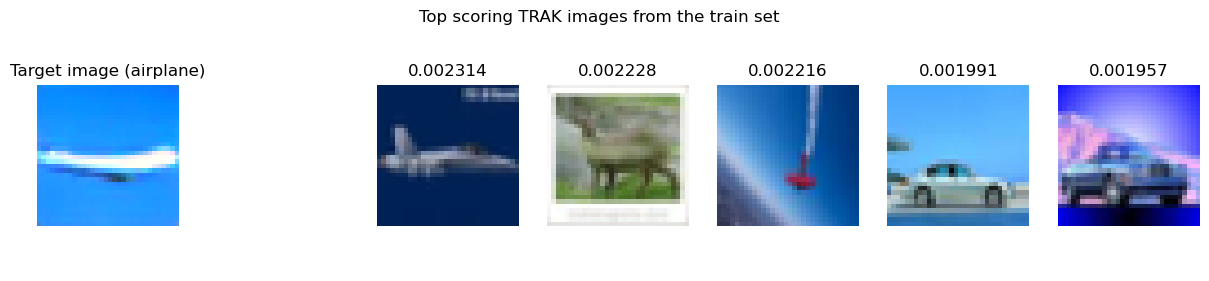

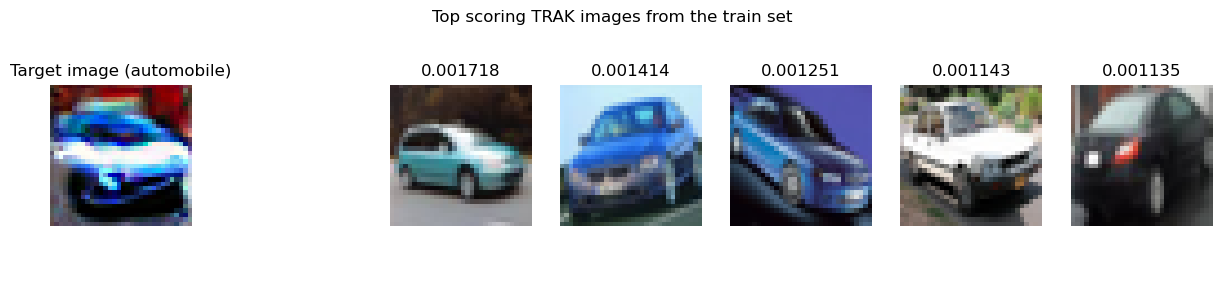

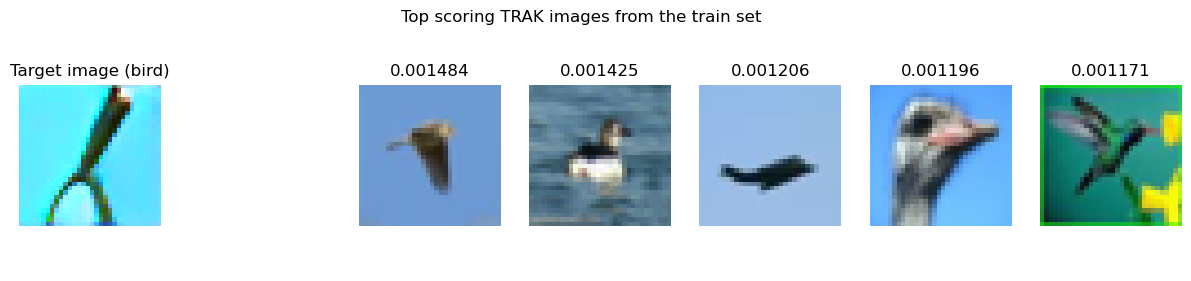

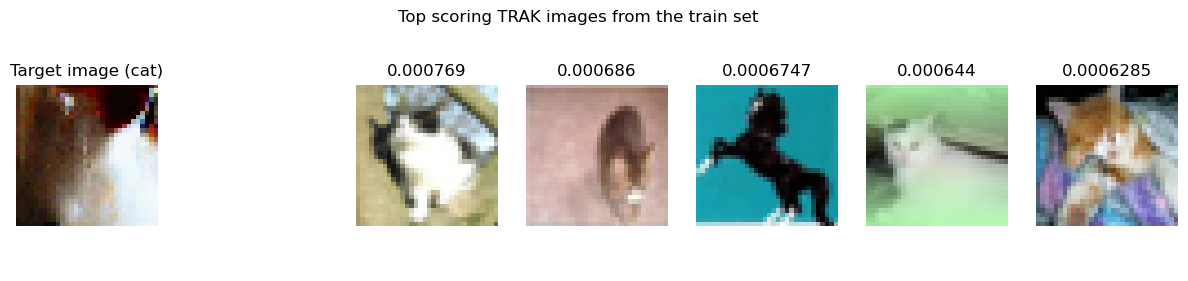

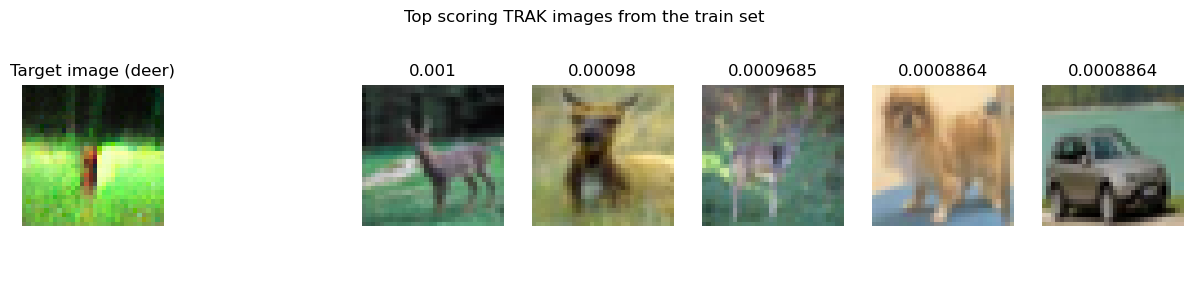

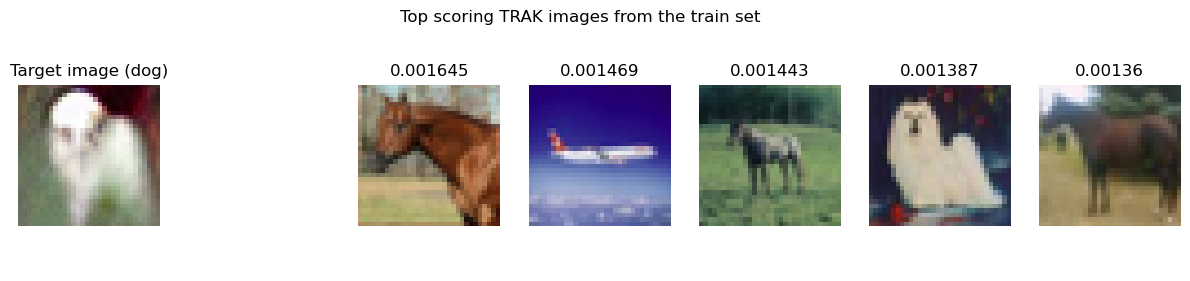

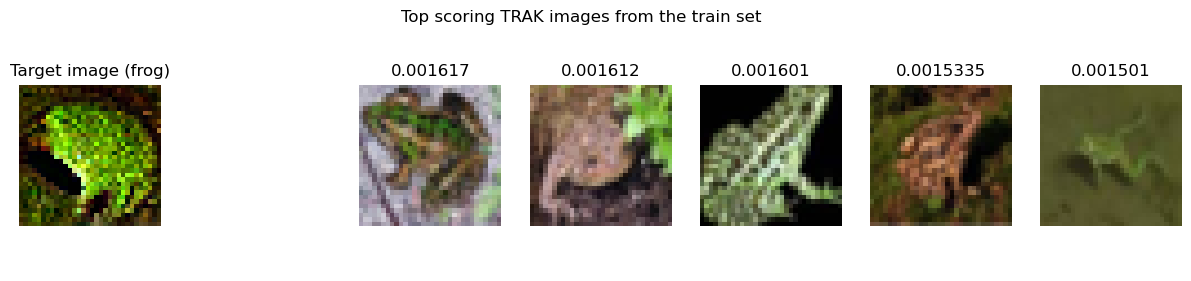

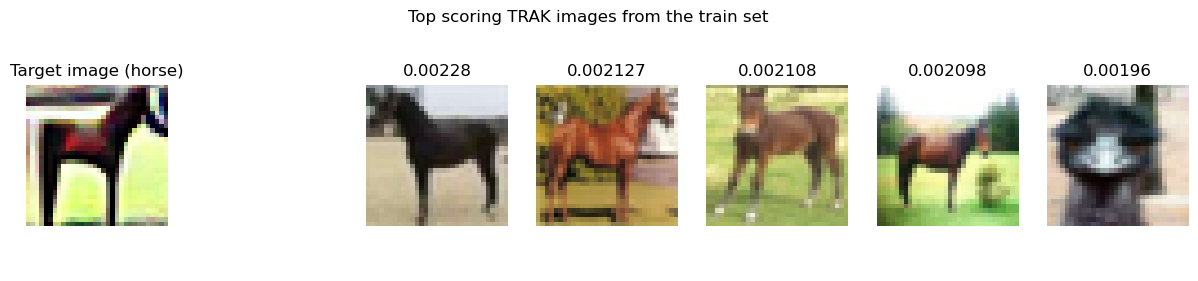

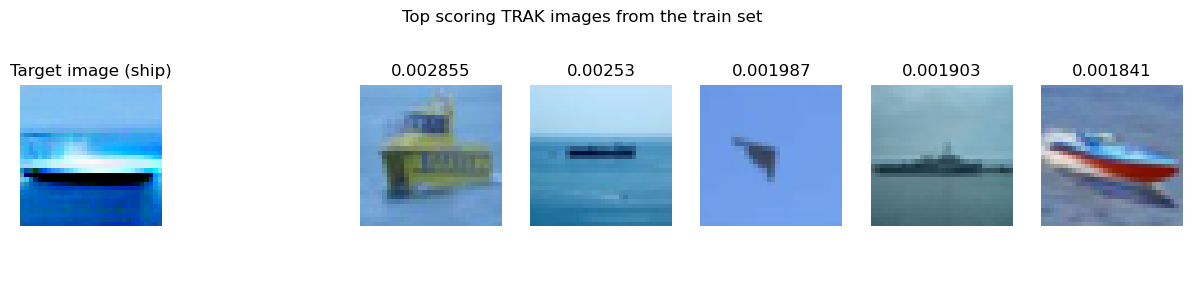

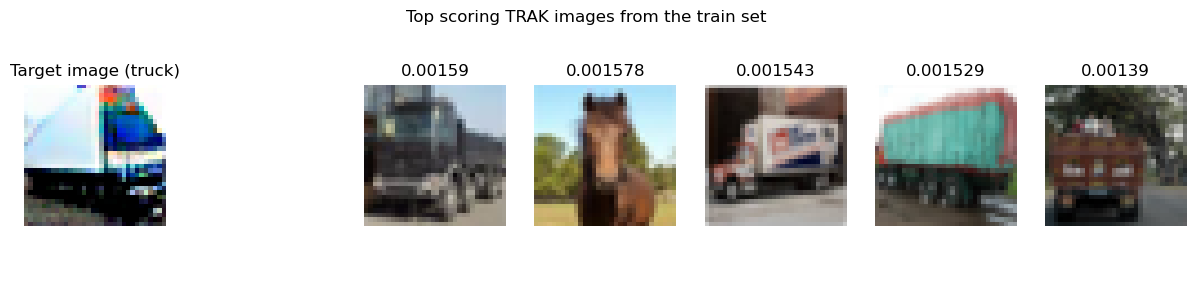

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

scores = trak_config.load_scores()

#print(scores.shape)

#scores = scores*0
#Scale the scores s.t. min is 0 and the sum is 1
#for i in range(10):
#    if scores[:,i].min() < 0:
#        scores[:,i] -= scores[:,i].min()
#    scores[:,i] *= (1/scores[:,i].sum())

if CALCULATE_LDS:
    print(f"LDS: {LDS(scores,generated_dataloader,10)*100}%")

NUM_SEEDS = 20
SEED_TO_PREVIEW = 1
for i in range(SEED_TO_PREVIEW,10*NUM_SEEDS,NUM_SEEDS): #[6]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(generated_dataset[i][generated_dataset_config.image_column])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + generated_dataset[i][generated_dataset_config.caption_column] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)][generated_dataset_config.image_column])
        axs[ii + 2].axis('off')
        axs[ii + 2].set_title(str(scores[int(train_im_ind),i]))

    fig.show()

In [9]:
from counter_factuals.counter_factuals_utils import Counter_Factual_Dataset_Generator
cfds = Counter_Factual_Dataset_Generator()

In [10]:
prompts = train_dataset_config.class_captions

In [11]:
#I'm having exactly none of numpy's memmap BS today
scores_c = np.copy(scores_org)

TARGET_CLASS: frog
TARGET_SEED: 1
TARGET_IMAGE: 6


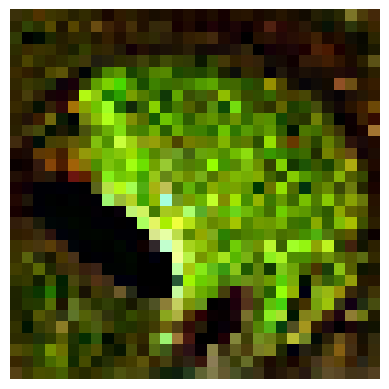

In [16]:
TARGET_CLASS = "frog"
assert(TARGET_CLASS in prompts)
print(f"TARGET_CLASS: {TARGET_CLASS}")
print(f"TARGET_SEED: {SEED_TO_PREVIEW}")

TARGET_IMAGE = prompts.index(TARGET_CLASS) #Seed 1, frog
print(f"TARGET_IMAGE: {TARGET_IMAGE}")
plt.axis('off')
i = SEED_TO_PREVIEW+(TARGET_IMAGE*NUM_SEEDS)
plt.imshow(generated_dataset[i][generated_dataset_config.image_column])

top_trak_scorers = scores_c[:, i].argsort()[-1000:][::-1]

#top_n_i, top_n_s = calculate_DINO_Attribution(generated_images[TARGET_IMAGE],1000)
#top_n_i = top_n_i.numpy()

In [17]:
top_n_i_list = top_trak_scorers.tolist()

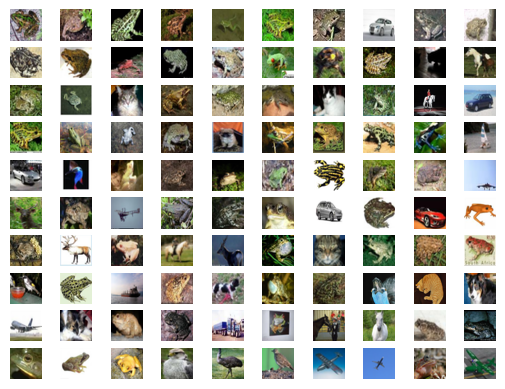

In [18]:
num_images_per_axis = 10
for i in range(num_images_per_axis**2):
    plt.subplot(num_images_per_axis, num_images_per_axis, i+1)
    plt.axis('off')
    plt.imshow(train_dataset_config.dataset[top_n_i_list[i]][train_dataset_config.image_column])

In [ ]:
#cfds.generate_base_dataset()
if IS_DTRAK:
    counterfactual_name = "DTRAK"
else:
    counterfactual_name = "TRAK"

MODEL_NAME_CLEAN = trak_config.MODEL_NAME_CLEAN

if GENERATE_COUNTER_FACTUAL_DATASET:
    cfds.create_counterfactual_config(f"{counterfactual_name}_{MODEL_NAME_CLEAN}_{TARGET_CLASS}_seed_{SEED_TO_PREVIEW}",top_n_i_list)